In [1]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, Layout, HBox
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

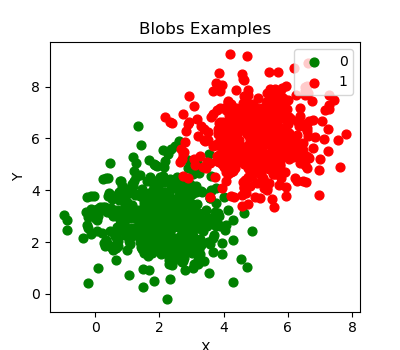

In [2]:
# We need to plot x, y --- features, z --- labels (n classes)

# Good dataset
from sklearn.datasets import make_blobs

centers = [[2,3],[5,6]]
data, labels = make_blobs(n_samples = 1000, centers= np.array(centers) , random_state = 100)
fig, ax = plt.subplots(figsize = (4,3.5))

colours = ('green', "red")
for label in range(len(centers)):
    ax.scatter(x=data[labels==label, 0], 
               y=data[labels==label, 1], 
               c=colours[label], 
               s=40, 
               label=label)

ax.set(xlabel='X',
       ylabel='Y',
       title='Blobs Examples')


ax.legend(loc='upper right')

In [3]:
# Binary classifier

class BinNet(nn.Module):
    def __init__(self, _in, _out):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(_in, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
            nn.Sigmoid(),
            nn.Linear(3, _out),
            nn.Sigmoid(),
        
        )
    
    def forward(self, x):
        return self.model(x)
    
    
model = BinNet(2, 1)

In [4]:
EPOCH = 20 

x_train_data = torch.Tensor(data)
y_train_data = torch.Tensor(labels).unsqueeze(1)

print(x_train_data.shape, y_train_data.shape)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.1)

print("Training")
# Training loop
for epoch in range(EPOCH):
    
    # Forward
    ypred = model.forward(x_train_data)
    
    # Zero-grad
    optimizer.zero_grad()
    
    # Backward
    loss = criterion(ypred, y_train_data)
    loss.backward()
    
    # Update
    optimizer.step()
    
    print(f"epoch {epoch}, loss: {loss.item()}")

torch.Size([1000, 2]) torch.Size([1000, 1])
Training
epoch 0, loss: 0.6930206418037415
epoch 1, loss: 0.6919602155685425
epoch 2, loss: 0.6896262168884277
epoch 3, loss: 0.6842426061630249
epoch 4, loss: 0.680117666721344
epoch 5, loss: 0.6754531860351562
epoch 6, loss: 0.6682126522064209
epoch 7, loss: 0.6588387489318848
epoch 8, loss: 0.6465423703193665
epoch 9, loss: 0.6310634613037109
epoch 10, loss: 0.6129420399665833
epoch 11, loss: 0.5927078127861023
epoch 12, loss: 0.5683844089508057
epoch 13, loss: 0.5420134663581848
epoch 14, loss: 0.513154923915863
epoch 15, loss: 0.4816858768463135
epoch 16, loss: 0.4485400915145874
epoch 17, loss: 0.41325125098228455
epoch 18, loss: 0.3761920630931854
epoch 19, loss: 0.3381904661655426


(10000,) (10000,)


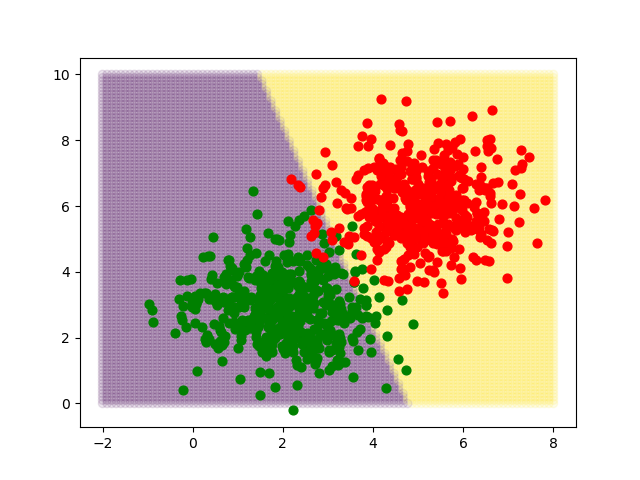

In [5]:
y = model.forward(x_train_data).detach().numpy()


fig, ax = plt.subplots()
X, Y = np.mgrid[-2:8:100j,0:10:100j]
X = X.flatten()
Y = Y.flatten()

print(X.shape, Y.shape)

# Visualize decision boundary 
colors = {0: 'red', 1: 'blue'}
pred = [1 if model.forward(torch.Tensor([x,y])).detach().numpy() > 0.5 else 0 for x, y in zip(X, Y)]

ax.scatter(X, Y, alpha = 0.1, c = pred)
for label in range(len(centers)):
    ax.scatter(x=data[labels==label, 0], 
               y=data[labels==label, 1], 
               c=colours[label], 
               s=40, 
               label=label)
plt.show()


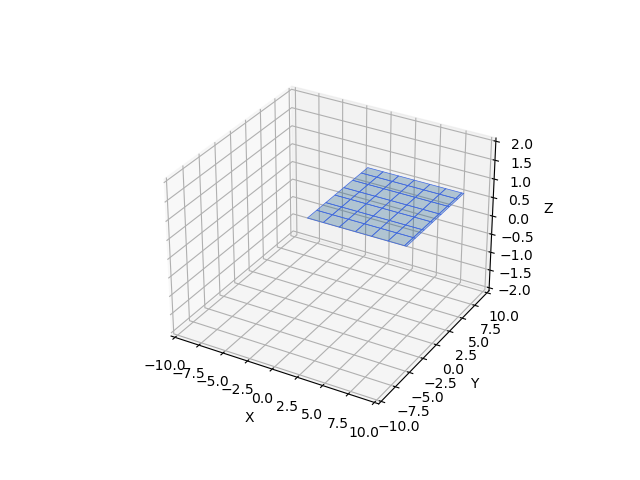

In [6]:
# set up plot
from mpl_toolkits.mplot3d import axes3d

ax = plt.figure().add_subplot(projection='3d')

x = np.linspace(0, 2 * np.pi, 100)

def my_sine(x, w, amp, phi):
    return amp*np.sin(w * (x-phi))

X, Y = np.meshgrid(np.arange(-2, 8, 0.2), np.arange(-1, 10, 0.2))
shape = X.shape

kwargs = {}    
kwargs_vals = {}    
kwargs_range = {}    
g_counter = 0
def recursive_modify(t: torch.Tensor, param_key: str, index: int = 0) -> None:
    global g_counter
    if t.dim() == 1:
        for i in range(len(t)):
            kwargs.setdefault(f"w{g_counter}", (param_key, index, i, t.data[i]))
            kwargs_vals.setdefault(f"w{g_counter}", float(t.data[i].item()))
            kwargs_range.setdefault(f"w{g_counter}", (-3, 3, 0.01))
            g_counter += 1
    else:
        for i, subt in enumerate(t):
            recursive_modify(subt, param_key, index + i)

for name, p in model.named_parameters():
    recursive_modify(p, name)


glob_kwargs_vals = kwargs_vals

# Create a list to store the sliders
sliders = []

# Populate the list with sliders
for key, (min_val, max_val, step) in kwargs_range.items():
    slider = widgets.FloatSlider(value=0, min=min_val, max=max_val, step=step, description=key, layout={'width': '20%'}, orientation= 'vertical')
    sliders.append(slider)

# Create a layout for the sliders
slider_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='80%')

# Create a container for the sliders
slider_container = HBox(sliders, layout=slider_layout)

# Display the vertically stacked sliders
display(slider_container)

# Create a list of sliders
# @widgets.interact(**kwargs_range)
def update(**kwargs_vals):
    global glob_kwargs_vals 
    for key, value in glob_kwargs_vals.items():
        if key in kwargs_vals and kwargs_vals[key] != value:
            # print(f"slider moved: ", key)
            param_key, index, subindex, val = kwargs[key]
            new_val = torch.Tensor([kwargs_vals[key]])
            
            prev_loc = torch.Tensor([glob_kwargs_vals[key]]).item()
            if 'bias' in param_key:
                updated_val = model.state_dict()[param_key].data[subindex] + (new_val.item() - prev_loc)
                model.state_dict()[param_key].data[subindex] = updated_val
            else:
                updated_val = model.state_dict()[param_key].data[index][subindex] + (new_val.item() - prev_loc)
                model.state_dict()[param_key].data[index][subindex] = updated_val
    glob_kwargs_vals = kwargs_vals
    
    input_ = torch.Tensor([[x, y] for x, y in zip(X.flatten(), Y.flatten())])
    pred = model.forward(input_)
    Z = pred.detach().numpy().reshape(shape[0], shape[1])
    
    ax.clear() # clear canvas/ Remove old lines from plot and plot new one

    # Plot the 3D surface
    ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                    alpha=0.3)

    # Projected contours sit on the walls of the 3D graph
    ax.contourf(X, Y, Z, zdir='z', offset=-100, cmap='coolwarm')
    ax.contourf(X, Y, Z, zdir='x', offset=-10, cmap='coolwarm')
    ax.contourf(X, Y, Z, zdir='y', offset=15, cmap='coolwarm')

    ax.set(xlim=(-10, 10), ylim=(-10, 10), zlim=(-2, 2),
           xlabel='X', ylabel='Y', zlabel='Z')
    

# Update the plot when sliders change
def on_slider_change(change, slider):
    update(**{slider.description: change.new})

for slider in sliders:
    slider.observe(lambda change, slider=slider: on_slider_change(change, slider), names='value')

# Initial plot
update(**{slider.description: slider.value for slider in sliders})


In [ ]:
# Ideas:
# 1. Initialize sliders with trained weights, so we can immediately see the optimized topology
# 1b. Plot the dataset on the X,Y plane
# 2. Use interactive plots that visualizes how the topology changes across each optimization step